In [100]:
import pandas as pd
import torch
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Understanding the Dataset

In [101]:
df = pd.read_csv('data/flights.csv')
# take only january data
df = df[df['MONTH'] == 1]
df_airports = pd.read_csv('data/airports.csv')
df_airlines = pd.read_csv('data/airlines.csv')

/Users/teframartin/Informatik/Swisscom/.conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3577: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [102]:
# some cleaning
df_flights = df[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'ARRIVAL_DELAY', 'AIRLINE', 'DISTANCE', 'ARRIVAL_TIME', 'DAY', 'MONTH', 'YEAR']]

df_flights = df_flights.dropna()

month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

def time_format(row):
    hour = int(row['ARRIVAL_TIME'] // 100) % 24
    minute = int(row['ARRIVAL_TIME'] % 100)

    return f"{hour:02d}:{minute:02d}:00"


df_flights['ARRIVAL_DATE_TIME'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + 
                                 df['MONTH'].astype(str) + '-' + 
                                 df['DAY'].astype(str) + ' ' + 
                                 df_flights.apply(time_format, axis=1))

df_flights = df_flights.drop(columns=['ARRIVAL_TIME', 'DAY', 'MONTH'])
df_flights.sort_values(by=['ARRIVAL_DATE_TIME'], inplace=True)
df_flights.head()

,ORIGIN_AIRPORT,DESTINATION_AIRPORT,ARRIVAL_DELAY,AIRLINE,DISTANCE,YEAR,ARRIVAL_DATE_TIME
12723,DFW,MCO,25.0,AA,985,2015,2015-01-01 00:00:00
13542,SEA,LAX,-23.0,AS,954,2015,2015-01-01 00:00:00
8944,PHX,MIA,117.0,AA,1972,2015,2015-01-01 00:00:00
12767,MDW,TPA,11.0,WN,997,2015,2015-01-01 00:01:00
9562,SNA,EWR,-45.0,UA,2434,2015,2015-01-01 00:01:00


In [103]:
# some cleaning
# df = df[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'AIRLINE', 'DISTANCE', 'ARRIVAL_TIME']]

df_flights = df_flights.dropna()

# discard flights with airport codes that are not in the airports dataset
df_flights = df_flights[df_flights['ORIGIN_AIRPORT'].isin(df_airports['IATA_CODE'])]
# discard flights with airline codes that are not in the airlines dataset
df_flights = df_flights[df_flights['AIRLINE'].isin(df_airlines['IATA_CODE'])]

df_flights['AIRPORT'] = df_flights['DESTINATION_AIRPORT']

df_flights['ORIGIN_AIRPORT'] = pd.Categorical(df_flights['ORIGIN_AIRPORT'])
df_flights['DESTINATION_AIRPORT'] = pd.Categorical(df_flights['DESTINATION_AIRPORT'])
df_flights['AIRLINE'] = pd.Categorical(df_flights['AIRLINE'])

df_flights['ORIGIN_AIRPORT'] = df_flights['ORIGIN_AIRPORT'].cat.codes
df_flights['DESTINATION_AIRPORT'] = df_flights['DESTINATION_AIRPORT'].cat.codes
df_flights['AIRLINE'] = df_flights['AIRLINE'].cat.codes

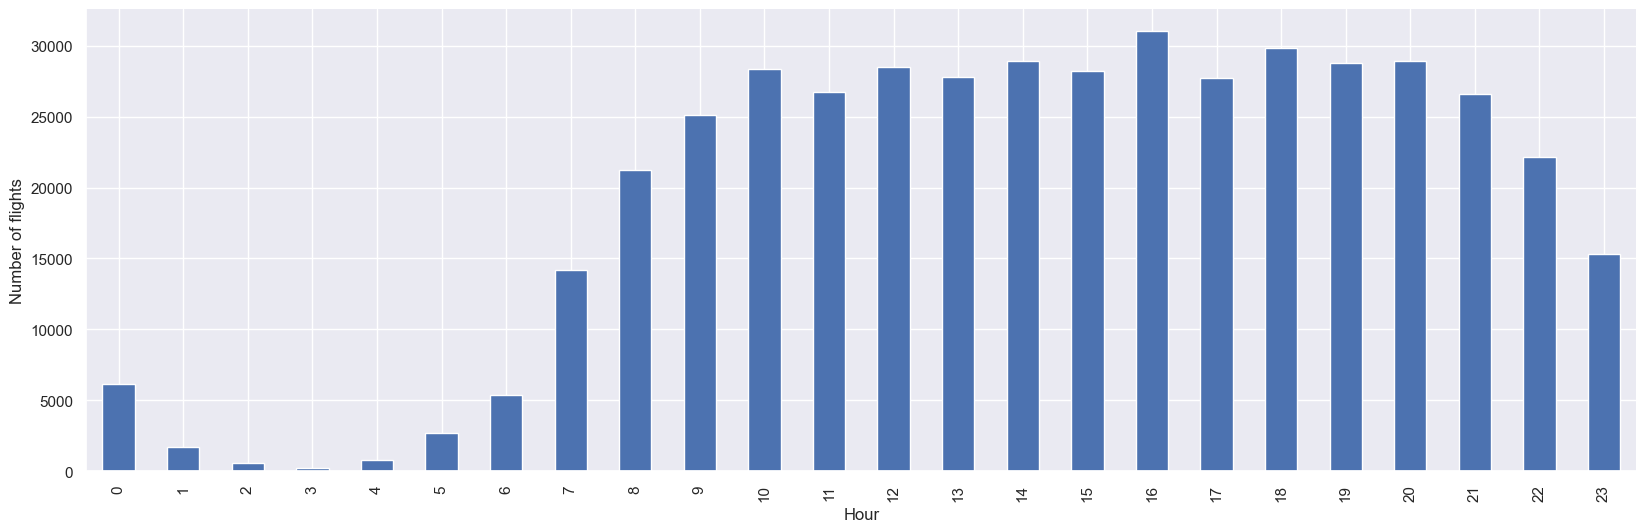

In [105]:
sns.set(rc={'figure.figsize':(20,6)})

# arrivals per hour
df_flights['ARRIVAL_DATE_TIME'].groupby(df_flights.ARRIVAL_DATE_TIME.dt.hour).count().plot(kind="bar")
# labels
plt.xlabel('Hour')
plt.ylabel('Number of flights')
sns.despine()

<Axes: xlabel='ARRIVAL_DATE_TIME'>

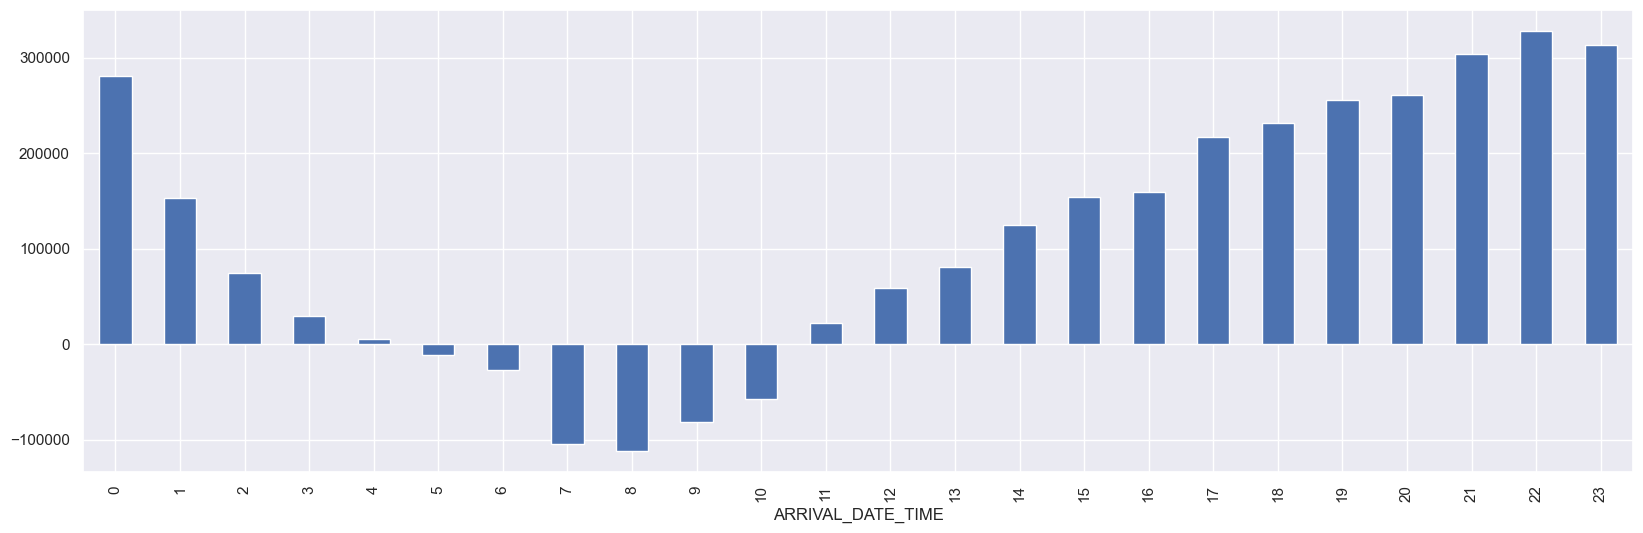

In [106]:
# plot cumulated delays per hour
df_flights['ARRIVAL_DELAY'].groupby(df_flights.ARRIVAL_DATE_TIME.dt.hour).sum().plot(kind="bar")

<Axes: xlabel='AIRLINE'>

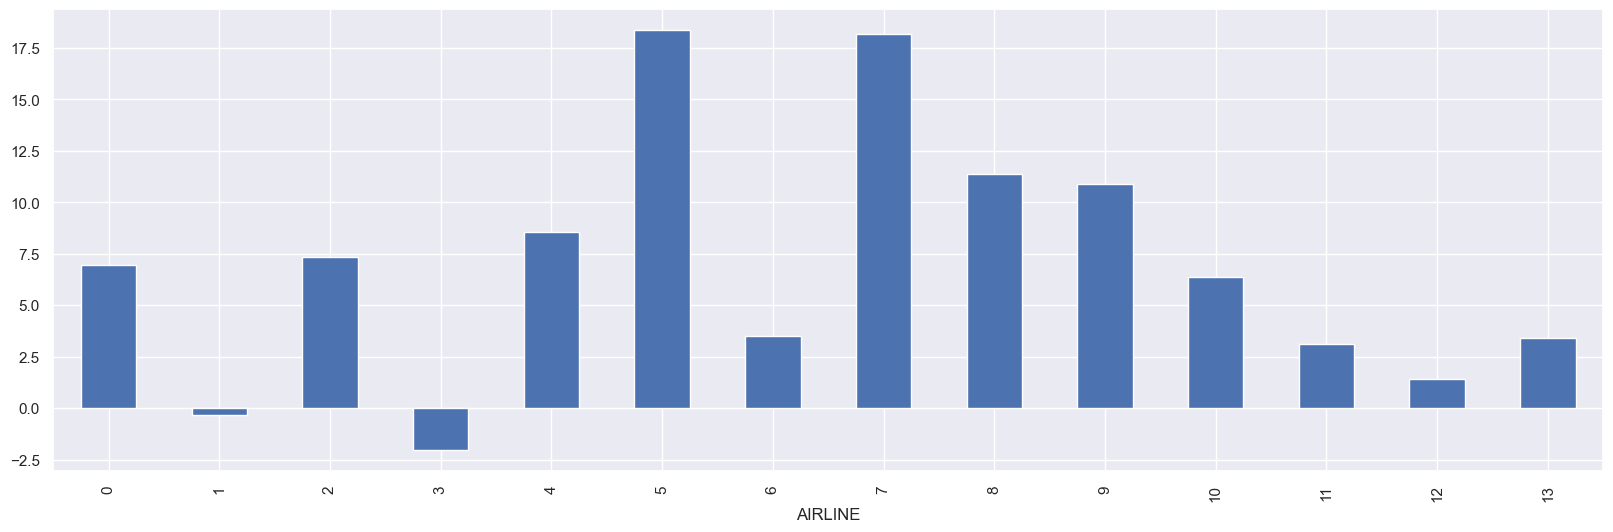

In [107]:
# plot average delay per airline
df_flights['ARRIVAL_DELAY'].groupby(df_flights.AIRLINE).mean().plot(kind="bar")

<Axes: >

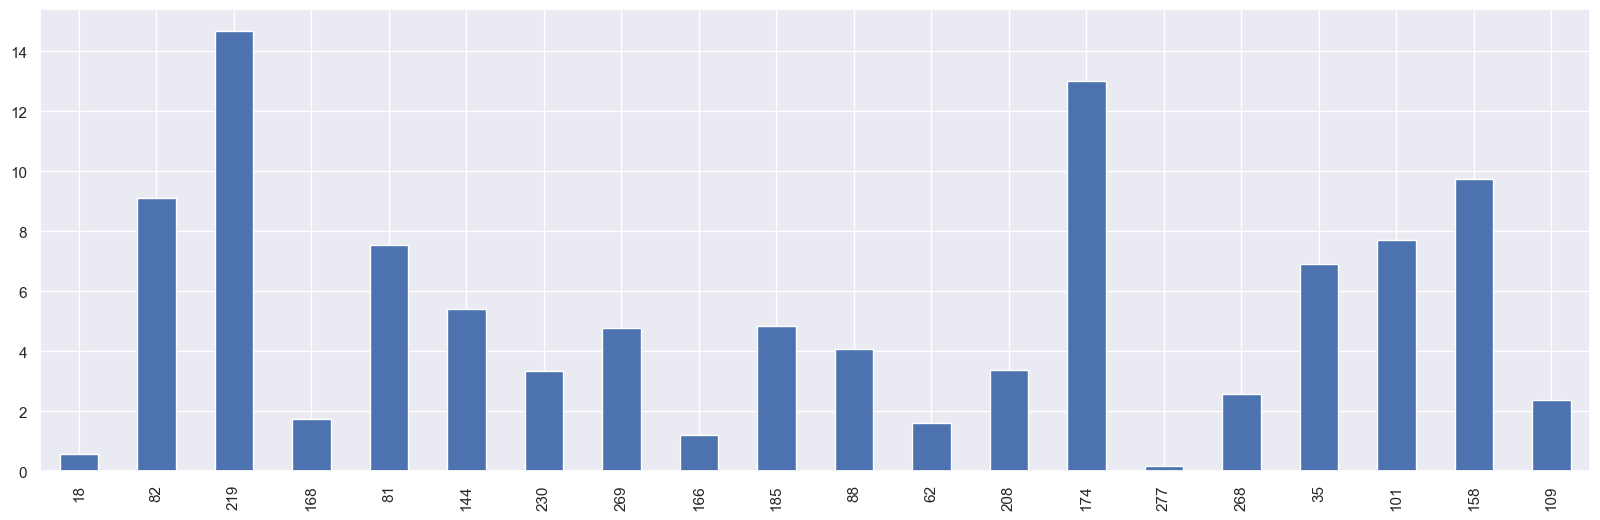

In [108]:
# plot average delay per airport for the 20 biggest airports
biggest_airports = df_flights['DESTINATION_AIRPORT'].value_counts().index[:20]
df_flights['ARRIVAL_DELAY'].groupby(df_flights.DESTINATION_AIRPORT).mean().loc[biggest_airports].plot(kind="bar")

# 2. Preprocessing the Data

In [308]:
df_flights

,ORIGIN_AIRPORT,DESTINATION_AIRPORT,ARRIVAL_DELAY,AIRLINE,DISTANCE,YEAR,ARRIVAL_DATE_TIME,AIRPORT
12723,82,185,25.0,0,985,2015,2015-01-01 00:00:00,MCO
13542,268,168,-23.0,1,954,2015,2015-01-01 00:00:00,LAX
8944,230,195,117.0,0,1972,2015,2015-01-01 00:00:00,MIA
12767,187,294,11.0,13,997,2015,2015-01-01 00:01:00,TPA
9562,280,101,-45.0,10,2434,2015,2015-01-01 00:01:00,EWR
...,...,...,...,...,...,...,...,...
469884,219,208,-8.0,7,334,2015,2015-01-31 23:59:00,MSP
469812,62,208,4.0,11,930,2015,2015-01-31 23:59:00,MSP
466644,135,166,14.0,6,2762,2015,2015-01-31 23:59:00,LAS
469827,62,185,3.0,11,468,2015,2015-01-31 23:59:00,MCO


In [309]:
# print avg delay for each destination for each hour for every day

# Step 1: Convert ARRIVAL_DATE_TIME to datetime
df['ARRIVAL_DATE_TIME'] = pd.to_datetime(df_flights['ARRIVAL_DATE_TIME'])

# Step 2: Group by DESTINATION_AIRPORT and the hour of ARRIVAL_DATE_TIME, then calculate the mean ARRIVAL_DELAY
avg_delay_per_hour = df.groupby(['DESTINATION_AIRPORT', df['ARRIVAL_DATE_TIME'].dt.floor('H')])['ARRIVAL_DELAY'].mean().reset_index(name='AVERAGE_ARRIVAL_DELAY')

# Step 3: Optional - Reset the index if you want a clean DataFrame
avg_delay_per_hour = avg_delay_per_hour.reset_index(drop=True)

In [310]:
avg_delay_per_hour

,DESTINATION_AIRPORT,ARRIVAL_DATE_TIME,AVERAGE_ARRIVAL_DELAY
0,ABE,2015-01-01 15:00:00,1.0
1,ABE,2015-01-01 16:00:00,-21.0
2,ABE,2015-01-01 20:00:00,-12.0
3,ABE,2015-01-01 22:00:00,-2.0
4,ABE,2015-01-02 15:00:00,-17.0
...,...,...,...
82670,YUM,2015-01-30 17:00:00,98.0
82671,YUM,2015-01-30 23:00:00,26.0
82672,YUM,2015-01-31 10:00:00,-5.0
82673,YUM,2015-01-31 12:00:00,11.0


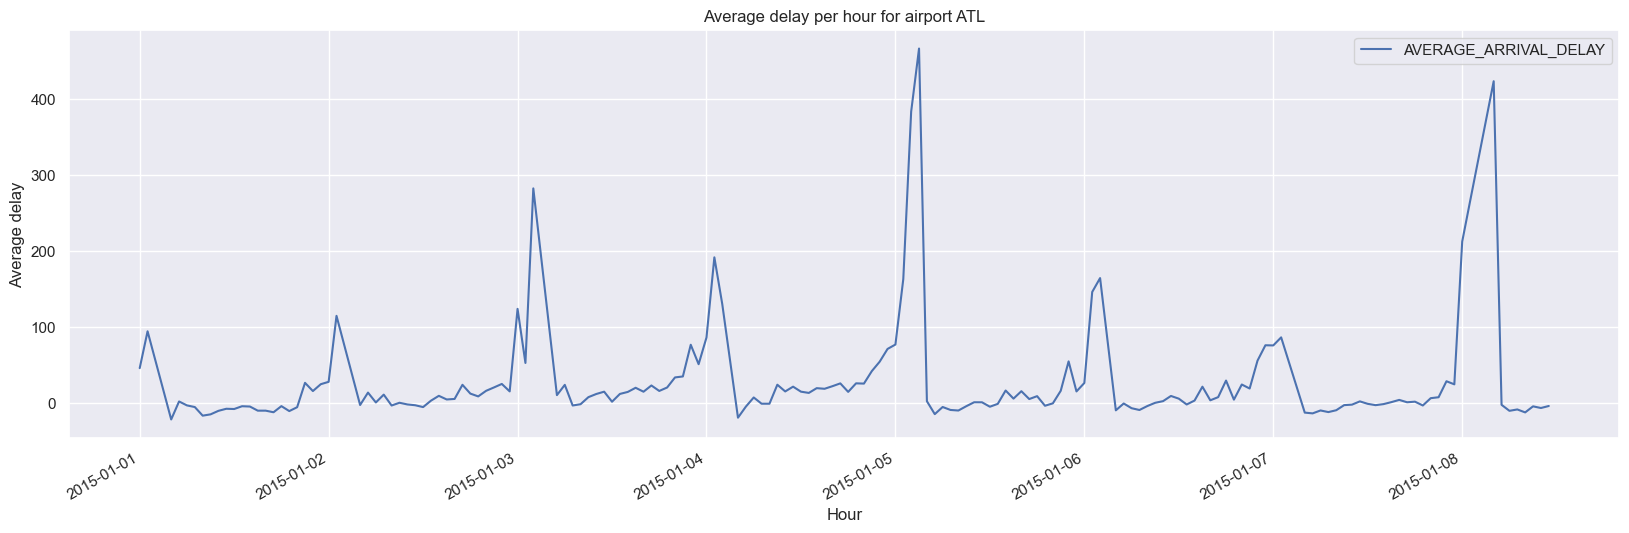

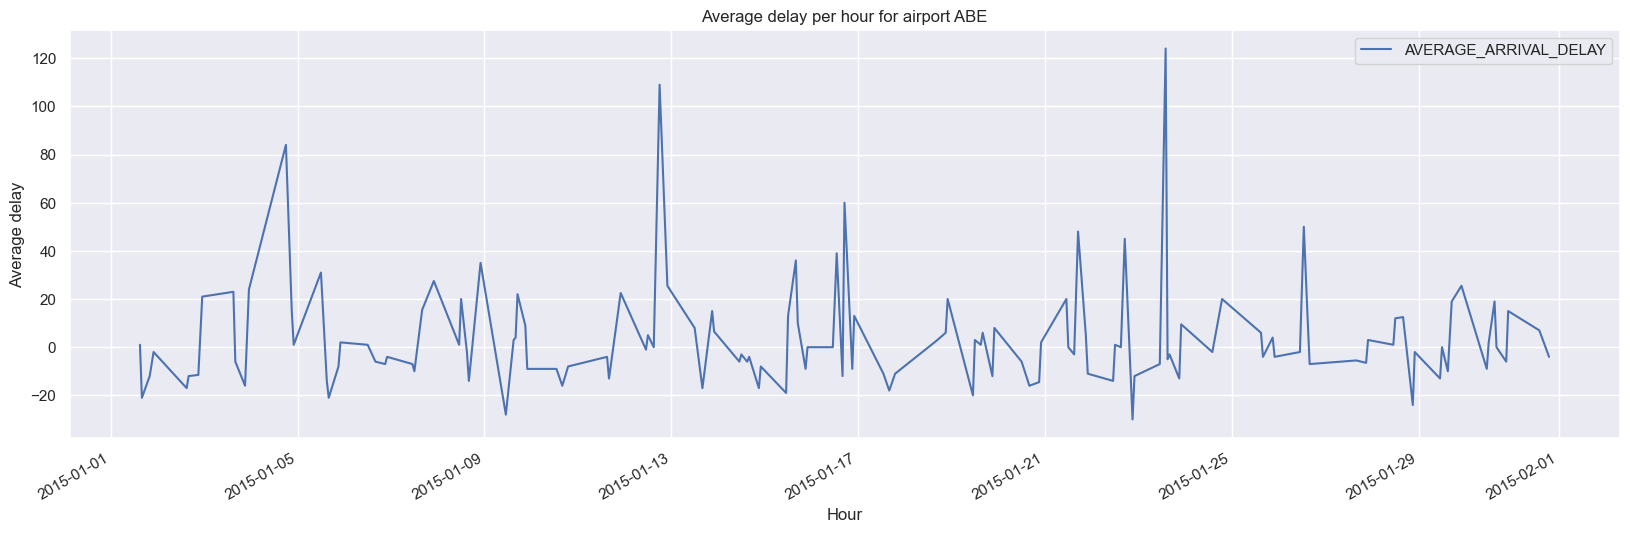

In [311]:
# plot avg_delay_per_hour for 1 airport
airports = ["ATL", "ABE"]
number_hours_week = 24 * 7
for airport in airports:
    avg_delay_per_hour[avg_delay_per_hour['DESTINATION_AIRPORT'] == airport][0:number_hours_week].plot(x='ARRIVAL_DATE_TIME', y='AVERAGE_ARRIVAL_DELAY')
    # labels
    plt.xlabel('Hour')
    plt.ylabel('Average delay')
    plt.title(f'Average delay per hour for airport {airport}')

In [312]:
avg_delay_per_hour

,DESTINATION_AIRPORT,ARRIVAL_DATE_TIME,AVERAGE_ARRIVAL_DELAY
0,ABE,2015-01-01 15:00:00,1.0
1,ABE,2015-01-01 16:00:00,-21.0
2,ABE,2015-01-01 20:00:00,-12.0
3,ABE,2015-01-01 22:00:00,-2.0
4,ABE,2015-01-02 15:00:00,-17.0
...,...,...,...
82670,YUM,2015-01-30 17:00:00,98.0
82671,YUM,2015-01-30 23:00:00,26.0
82672,YUM,2015-01-31 10:00:00,-5.0
82673,YUM,2015-01-31 12:00:00,11.0


In [433]:
import numpy as np
import pandas as pd

# get the number of unique airports
unique_airports = avg_delay_per_hour['DESTINATION_AIRPORT'].nunique()
# get the number of unique hours (assuming the number of unique hours should relate to the granularity you need)
unique_hours = avg_delay_per_hour['ARRIVAL_DATE_TIME'].nunique()
# Assuming each "row" represents a unique [Airport, DateTime] combination, otherwise adjust accordingly

# Instead of directly using number_rows in the shape, we calculate an adjusted size to avoid shape mismatch
# Each airport will have a number of entries equal to the number of unique hours in the dataset for consistency
adjusted_size = unique_airports * unique_hours

# Initialize the data array with NaNs to accommodate missing data
data = np.full((unique_airports, 1, adjusted_size), np.nan)

# Convert ARRIVAL_DATE_TIME to datetime for sorting and manipulation
avg_delay_per_hour['ARRIVAL_DATE_TIME'] = pd.to_datetime(avg_delay_per_hour['ARRIVAL_DATE_TIME'])

# Sort DataFrame by 'DESTINATION_AIRPORT' and 'ARRIVAL_DATE_TIME' for consistent ordering
avg_delay_per_hour.sort_values(by=['DESTINATION_AIRPORT', 'ARRIVAL_DATE_TIME'], inplace=True)

# Mapping of airports to indices in the data array
airport_to_index = {airport: i for i, airport in enumerate(avg_delay_per_hour['DESTINATION_AIRPORT'].unique())}

# Populate the data array
for i, row in avg_delay_per_hour.iterrows():
        
    airport_index = airport_to_index[row['DESTINATION_AIRPORT']]
    # Assuming 'ARRIVAL_DATE_TIME' and 'AVERAGE_ARRIVAL_DELAY' are sequentially filled, find the next available slot
    for i in range(adjusted_size):
        if np.isnan(data[airport_index, 0, i]):
            # data[airport_index, 0, i] = row['ARRIVAL_DATE_TIME'].timestamp()  # Storing as timestamp for uniformity
            data[airport_index, 0, i] = row['AVERAGE_ARRIVAL_DELAY']
            break

# Now data is prepared; let's save it
np.save('data/airport_data.npy', data)

# Note: This code assumes each airport has entries for each unique hour across the dataset, which may lead to sparse matrices.
# You might need to adjust the logic based on your actual dataset's


In [451]:
from flights_dataset_loader import FlightsDatasetLoader

data = FlightsDatasetLoader().get_dataset(num_timesteps_in=21)

AttributeError: 'FlightsDatasetLoader' object has no attribute '_generate_dynamic_edges_and_weights'

In [ ]:
next(iter(data))

Data(x=[312, 1, 21], edge_index=[2, 312], edge_attr=[312], y=[312, 12])

In [445]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=32, 
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

TemporalGNN(node_features=1, periods=12)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(1, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(1, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(1, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

In [448]:
print(snapshot.x.shape)
snapshot.x[0:20][:][0:20]

torch.Size([312, 1, 21])


tensor([[[-0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081,
          -0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081,
          -0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081]],

        [[-0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081,
          -0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081,
          -0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081]],

        [[-0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081,
          -0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081,
          -0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081]],

        [[-0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081,
          -0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081,
          -0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081]],

        [[-0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081, -0.0081,
          -0.0081, -0.0081, -0.0081, -0

In [447]:
# GPU support
device = torch.device('cpu') # cuda
subset = 2000

# Create model and optimizers
model = TemporalGNN(node_features=1, periods=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

print("Running training...")
for epoch in range(10): 
    print("Epoch {}".format(epoch))
    loss = 0
    step = 0
    for snapshot in data:
        snapshot = snapshot.to(device)
        # Get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index)
        # Mean squared error
        loss = loss + torch.nanmean((y_hat-snapshot.y)**2) if torch.nanmean((y_hat-snapshot.y)**2) is not np.nan else loss
        step += 1
        if step > subset:
          break

    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train MSE: {:.4f}".format(epoch, loss.item()))

Running training...
Epoch 0
Epoch 0 train MSE: 99.4245
Epoch 1
Epoch 1 train MSE: 98.7865
Epoch 2
Epoch 2 train MSE: 98.5362
Epoch 3
Epoch 3 train MSE: 98.1632
Epoch 4
Epoch 4 train MSE: 97.9704
Epoch 5
Epoch 5 train MSE: 97.7932
Epoch 6
Epoch 6 train MSE: 97.6416
Epoch 7
Epoch 7 train MSE: 97.4924
Epoch 8
Epoch 8 train MSE: 97.3592
Epoch 9
Epoch 9 train MSE: 97.2214


In [ ]:
# accuracy

### END ###

In [109]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
unique_edges = df_flights[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']].drop_duplicates()
unique_edges = unique_edges.reset_index(drop=True)

airports_dict = df_airports['IATA_CODE'].to_dict()
airports_dict = {v: k for k, v in airports_dict.items()}

In [133]:
# transform the data and save it as json file
import json

number_of_airports = len(airports_dict)
number_of_time_steps = 800

with open('data/flights.json', 'w') as f:
    
    json_data = {}
    json_data["edges"] = unique_edges.values.tolist()
    json_data["node_ids"] = airports_dict
    json_data["FX"] = np.random.normal(0, 1, [number_of_airports,number_of_time_steps]).tolist()
    
    # write the json data
    json.dump(json_data, f)

In [134]:
from flights import FlightsLoader

d = FlightsLoader().get_dataset()
next(iter(d))

Data(x=[800, 4], edge_index=[2, 4165], edge_attr=[4165], y=[800])

In [135]:
from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(d, train_ratio=0.8)

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = TGCN(node_features, 32)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight, prev_hidden_state):
        h = self.recurrent(x, edge_index, edge_weight, prev_hidden_state)
        y = F.relu(h)
        y = self.linear(y)
        return y, h

model = RecurrentGCN(node_features = 4)

# Create model and optimizers
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

model.train()

for epoch in tqdm(range(50)):
    cost = 0
    hidden_state = None
    for time, snapshot in enumerate(train_dataset):
        y_hat, hidden_state = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr,hidden_state)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

print(cost)

model.eval()
cost = 0
hidden_state = None
for time, snapshot in enumerate(test_dataset):
    y_hat, hidden_state = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, hidden_state)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [02:37<00:00,  3.15s/it]


tensor(1.0015, grad_fn=<DivBackward0>)
MSE: 0.9986


In [136]:
# evaluttion
model.eval()
cost = 0
hidden_state = None
for time, snapshot in enumerate(test_dataset):
    y_hat, hidden_state = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, hidden_state)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))


MSE: 0.9986


In [146]:
import os
import urllib
import zipfile

In [354]:
class METRLADatasetLoader(object):
    """A traffic forecasting dataset based on Los Angeles
    Metropolitan traffic conditions. The dataset contains traffic
    readings collected from 207 loop detectors on highways in Los Angeles
    County in aggregated 5 minute intervals for 4 months between March 2012
    to June 2012.

    For further details on the version of the sensor network and
    discretization see: `"Diffusion Convolutional Recurrent Neural Network:
    Data-Driven Traffic Forecasting" <https://arxiv.org/abs/1707.01926>`_
    """

    def __init__(self, raw_data_dir=os.path.join(os.getcwd(), "data")):
        super(METRLADatasetLoader, self).__init__()
        self.raw_data_dir = raw_data_dir
        self._read_web_data()
                
    def _read_web_data(self):

        with zipfile.ZipFile(
            os.path.join(self.raw_data_dir, "METR-LA.zip"), "r"
        ) as zip_fh:
            zip_fh.extractall(self.raw_data_dir)

        A = np.load(os.path.join(self.raw_data_dir, "adj_mat.npy"))
        X = np.load(os.path.join(self.raw_data_dir, "node_values.npy")).transpose(
            (1, 2, 0)
        )
        X = X.astype(np.float32)

        # Normalise as in DCRNN paper (via Z-Score Method)
        # means = np.mean(X, axis=(0, 2))
        # X = X - means.reshape(1, -1, 1)
        # stds = np.std(X, axis=(0, 2))
        # X = X / stds.reshape(1, -1, 1)

        self.A = torch.from_numpy(A)
        self.X = torch.from_numpy(X)
        
data = METRLADatasetLoader()

In [355]:
print(data.X.shape)
data.X[0]

torch.Size([207, 2, 34272])


tensor([[6.4375e+01, 6.2667e+01, 6.4000e+01,  ..., 6.7000e+01, 6.6750e+01,
         6.5111e+01],
        [0.0000e+00, 3.4722e-03, 6.9444e-03,  ..., 9.8958e-01, 9.9306e-01,
         9.9653e-01]])

In [75]:
outgoing_flights = df_flights['ORIGIN_AIRPORT'].groupby(df_flights['ORIGIN_AIRPORT']).count().values
incoming_flights = df_flights['DESTINATION_AIRPORT'].groupby(df_flights['DESTINATION_AIRPORT']).count().values

# normalise
outgoing_flights = (outgoing_flights - np.min(outgoing_flights)) / (np.max(outgoing_flights) - np.min(outgoing_flights))
incoming_flights = (incoming_flights - np.min(incoming_flights)) / (np.max(incoming_flights) - np.min(incoming_flights))

node_features = np.stack([outgoing_flights, incoming_flights]).transpose()
print("Full shape: ", node_features.shape)
node_features[:10] # [num_nodes x num_features]

Full shape:  (312, 2)


array([[0.0051391 , 0.00504063],
       [0.0074003 , 0.00747523],
       [0.05334384, 0.05308096],
       [0.00174729, 0.00174879],
       [0.00239825, 0.00243459],
       [0.00455667, 0.00456057],
       [0.00469371, 0.00462915],
       [0.01113471, 0.01107568],
       [0.        , 0.        ],
       [0.00068521, 0.0006858 ]])

In [106]:
unique_trips = df_flights[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'AIRLINE']].drop_duplicates()
unique_trips = unique_trips.reset_index(drop=True)
edge_attr = unique_trips['AIRLINE'].values
len(edge_attr), edge_attr

(6512, array([0, 1, 0, ..., 3, 3, 9], dtype=int8))

In [125]:
edge_index = df_flights[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'AIRLINE']].drop_duplicates().reset_index(drop=True).drop(columns=['AIRLINE']).transpose().values
(len(edge_index), len(edge_index[0])), edge_index

((2, 6512),
 array([[ 82, 268, 230, ..., 267,  18, 219],
        [185, 168, 195, ...,  88, 111, 144]], dtype=int16))

In [180]:
start_date = datetime(2015, 1, 1, 1, 0, 0)
end_date = datetime(2015, 1, 31)
interval = timedelta(minutes=60)

xs = []
edge_indices = []
ys = []
y_indices = []
edge_features = []

while start_date < end_date:
    edge_indices.append(edge_index)
    edge_features.append(edge_attr)
    
    # get flights for the current hour
    mask = (df_flights['ARRIVAL_DATE_TIME'] >= start_date) & (df_flights['ARRIVAL_DATE_TIME'] < start_date + interval)
    flights = df_flights[mask]
    
    # get delays for the current hour
    delays = flights['ARRIVAL_DELAY'].values
    # y_indices get whether the average delay for each destination airport if any or a 0 if no flights
    
    
    outgoing_flights = df_flights['ORIGIN_AIRPORT'].groupby(df_flights['ORIGIN_AIRPORT']).count().values
    incoming_flights = df_flights['DESTINATION_AIRPORT'].groupby(df_flights['DESTINATION_AIRPORT']).count().values

    # normalise
    outgoing_flights = (outgoing_flights - np.min(outgoing_flights)) / (np.max(outgoing_flights) - np.min(outgoing_flights))
    incoming_flights = (incoming_flights - np.min(incoming_flights)) / (np.max(incoming_flights) - np.min(incoming_flights))

    node_features = np.stack([outgoing_flights, incoming_flights]).transpose()
    xs.append(node_features)

    
    
    start_date += interval


In [182]:
i =0
print(f"""Example of graph snapshot {i}: \n
      Node feature shape: {xs[i].shape} \n
      Edge index shape: {edge_indices[i].shape} \n
      Edge feature shape: {edge_features[i].shape} \n 
      Labels shape: {ys[i].shape} \n
      Labels mask shape: {y_indices[i].shape}
      """)

AttributeError: 'float' object has no attribute 'shape'

In [184]:
# plot mean arrival delay per hour
delays = []
for delay in ys:
    delays.append(np.mean(delay))
plt.plot(delays)
plt.xlabel('Hour')
plt.ylabel('Mean arrival delay')
plt.show()

NameError: name 'ys' is not defined

In [184]:
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal
dataset = DynamicGraphTemporalSignal(
            edge_indices, edge_features, xs, ys, y_indices=y_indices
        )

AssertionError: Temporal dimension inconsistency.

In [175]:
dataset[1]

Data(x=[312, 2], edge_index=[2, 6512], edge_attr=[6512], y=[21], y_indices=[21, 2])

# --- DATASET CONSTRUCTION SHOULD BE DONE ---

In [116]:
from torch_geometric.data import Data

# Step 1: Map airports to indices
airports = pd.concat([df['ORIGIN_AIRPORT'], df['DESTINATION_AIRPORT']]).unique()
airport_to_idx = {airport: i for i, airport in enumerate(airports)}

# Step 2: Create edge index
edge_index = torch.tensor([
    [airport_to_idx[o], airport_to_idx[d]] for o, d in zip(df['ORIGIN_AIRPORT'], df['DESTINATION_AIRPORT'])
], dtype=torch.long).t().contiguous()

# Step 3: Prepare edge attributes
edge_attr = torch.tensor(df[['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'AIRLINE', 'DISTANCE', 'ARRIVAL_TIME']].values, dtype=torch.float)

x = torch.tensor(df[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'AIRLINE', 'DISTANCE', 'ARRIVAL_TIME']].values, dtype=torch.float)
y = torch.tensor(df['ARRIVAL_DELAY'].values, dtype=torch.float)
edge_index = edge_index.t().contiguous()
edge_attr = edge_attr.t().contiguous()

data = Data(x=x, y=y, edge_index=edge_index, edge_attr=edge_attr)

In [117]:
import pandas as pd
import torch
from torch_geometric_temporal.signal.static_graph_temporal_signal import StaticGraphTemporalSignal

# Assuming df is your DataFrame and the necessary preprocessing has been done
# Define your static graph structure (edges)
edges = pd.concat([df['ORIGIN_AIRPORT'], df['DESTINATION_AIRPORT']], axis=1).drop_duplicates()
edges = edges.reset_index(drop=True)
edge_index = torch.tensor([edges['ORIGIN_AIRPORT'].values, edges['DESTINATION_AIRPORT'].values], dtype=torch.long)

# Prepare edge attributes for each flight (time step)
edge_attributes_list = []
targets_list = []

for _, row in df.iterrows():
    # edge_attributes = torch.tensor([row['DEPARTURE_DELAY'], row['ARRIVAL_DELAY'], row['AIRLINE'], row['DISTANCE']], dtype=torch.float)
    edge_attributes = torch.tensor([row['ARRIVAL_TIME']], dtype=torch.float)
    edge_attributes_list.append(edge_attributes.unsqueeze(0))  # Add a new dimension for time step
    targets_list.append(torch.tensor([row['ARRIVAL_DELAY']], dtype=torch.float))

# Assuming edge attributes do not change (which they do), we'd need to handle this differently for a real temporal dataset
edge_weights = torch.cat(edge_attributes_list, dim=0)  # Concatenate along the new time dimension

# Targets
targets = torch.cat(targets_list, dim=0)

node_features = torch.tensor(df[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']].values, dtype=torch.float)

# Create StaticGraphTemporalSignal
data = StaticGraphTemporalSignal(
    features=node_features,
    targets=targets,
    edge_index=edge_index,
    edge_weight=edge_weights
)

In [118]:
data.features

tensor([[208., 229.],
        [244., 275.],
        [268., 143.],
        ...,
        [ 88., 267.],
        [ 47., 108.],
        [ 82., 258.]])

In [85]:
# plot delays in time for a specific airport
import matplotlib.pyplot as plt

airport_number = 208
airport_data = data[data['features'][:, 0] == airport_number]
print(airport_data)


plt.plot(airport_data['targets'])
plt.xlabel('Time step')
plt.ylabel('Arrival delay')
# plt.title(f'Arrival delay for airport {airport}')
plt.show()


IndexError: too many indices for tensor of dimension 2

# 3. Building Models

In [202]:
from torch_geometric_temporal.signal import temporal_signal_split

train_dataset, test_dataset = temporal_signal_split(d, train_ratio=0.8)

In [203]:
next(iter(train_dataset))

Data(x=[3, 4], edge_index=[2, 4], edge_attr=[4], y=[3])

In [204]:
# model
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=32, 
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

TemporalGNN(node_features=5, periods=1)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(5, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(5, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(5, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [205]:
device = torch.device('cpu') # cuda

# Create model and optimizers
model = TemporalGNN(node_features=2, periods=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

# Train model
for epoch in range(100):
    optimizer.zero_grad()
    out = model(train_dataset.features
    loss = F.mse_loss(out, train_dataset.targets)
    loss.backward()
    optimizer.step()
    print(f'Epoch: {epoch}, Loss: {loss.item()}')
    

AttributeError: 'StaticGraphTemporalSignal' object has no attribute 'edge_indices'

# 4. Evaluation

In [90]:
# eval
model.eval()
with torch.no_grad():
    out = model(test_dataset.features.unsqueeze(-1), test_dataset.edge_index)
    loss = F.mse_loss(out, test_dataset.targets)
    print(f'Test Loss: {loss.item()}')
    print(out)
    print(test_dataset.targets)
    

Test Loss: 1611.7125244140625
tensor([[3.8294],
        [3.8294],
        [3.8294],
        ...,
        [3.8294],
        [3.8294],
        [3.8294]])
tensor([ 27., -10., -15.,  ...,  -7., -20., -21.])


/var/folders/07/9l9kqd013xjdlz8_0b2__8xr0000gq/T/ipykernel_26955/2727950371.py:5: UserWarning: Using a target size (torch.Size([9141])) that is different to the input size (torch.Size([9141, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, test_dataset.targets)


In [134]:
next(iter(train_dataset))

AttributeError: 'torch.dtype' object has no attribute 'kind'

In [132]:
import torch
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric_temporal.nn.attention.stgcn import TemporalConv
import torch.nn.functional as F

# Define a model
class TemporalGNN(torch.nn.Module):
    def __init__(self, num_nodes, node_features, edge_features):
        super(TemporalGNN, self).__init__()
        self.conv1 = GCNConv(node_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.temporal = TemporalConv(64, 64)
        self.lin = torch.nn.Linear(64, 1)
        
    def forward(self, x, edge_index, edge_attr, batch):
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        
        # Assuming edge_attr has shape [num_edges, time_steps, features]
        edge_attr = self.temporal(edge_attr)
        
        x = global_mean_pool(x, batch)  # Global pooling
        x = self.lin(x)
        return x
    
print(next(iter(data)))

# Initialize model
model = TemporalGNN(num_nodes=data.num_nodes, 
                    node_features=data.num_node_features,
                    edge_features=data.num_edge_features)

# Define a loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
for epoch in range(10):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr, data.batch)
    loss = criterion(out, data.targets)
    loss.backward()
    optimizer.step()


AttributeError: 'torch.dtype' object has no attribute 'kind'

# 5. Interpretation

# 6. Addressing the Challenge